In [1]:
# For better plotting
%matplotlib inline

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import open3d
import numpy as np 
import matplotlib.pyplot as plt 
import copy
import time
import os
import sys
import collections

from utils.lib_plot import plot_cloud_2d, plot_cloud_3d, plot_cloud_2d3d
from utils.lib_open3d_io import get_xyza, read_cloud, write_cloud
from utils.lib_cloud_proc import get_xy_from_latlon, downsample, filter_cloud
from utils.lib_cloud_proc import find_plannar_points_by_grid, find_plannar_points_by_kdtree
from utils.lib_plane import PlaneModel, fit_3D_line
from utils.lib_ransac import ransac
from utils.lib_clustering import Clusterer

t_start_running_this_jupyter_notebook = time.time()

# Define some common functions

In [3]:
def write_cloud_and_figure(filename, cloud):
    write_cloud(filename + '.pcd', cloud)
    plt.savefig(filename + '.jpg')

def split_into_columns(X): 
    ''' Split X into columns to form a list'''
    N_cols = X.shape[1]
    return [i.ravel() for i in np.hsplit(X, N_cols)]

def get_3d_line_equation(vec, p):
    ''' Get the string of 3d line equation from line parameters '''
    # vec: line direction
    # p: a point on the line
    vars = ['x', 'y', 'z']
    eqs = []
    for i in range(3):
        sign = '-' if p[i] > 0 else '+'
        s = "({}{}{:.2f})/({:.5f})".format(vars[i], sign, abs(p[i]), vec[i])
        eqs.append(s)
    return " == ".join(eqs)

# Create folder to store result
RES_FOLDER = "./result/"
if not os.path.exists(RES_FOLDER):
    os.makedirs(RES_FOLDER)

# Read cloud

In [4]:
# Read cloud data
# Each point has 4 attributes: [lat, lon, height, alpha (point intensity)]

filename_source_cloud = "data/final_project_point_cloud.fuse"
data = np.loadtxt(filename_source_cloud).astype(np.float32)
lats, lons, h, alpha = split_into_columns(data)


# Convert from (lat, lon) to local Cartesian (x, y) coordinate
xs, ys = get_xy_from_latlon(lats, lons)
xyza_src = np.column_stack((xs, ys, h, np.minimum(1.0, alpha/100.0)))

Time cost of plotting 2D/3D point cloud = 2.45 seconds


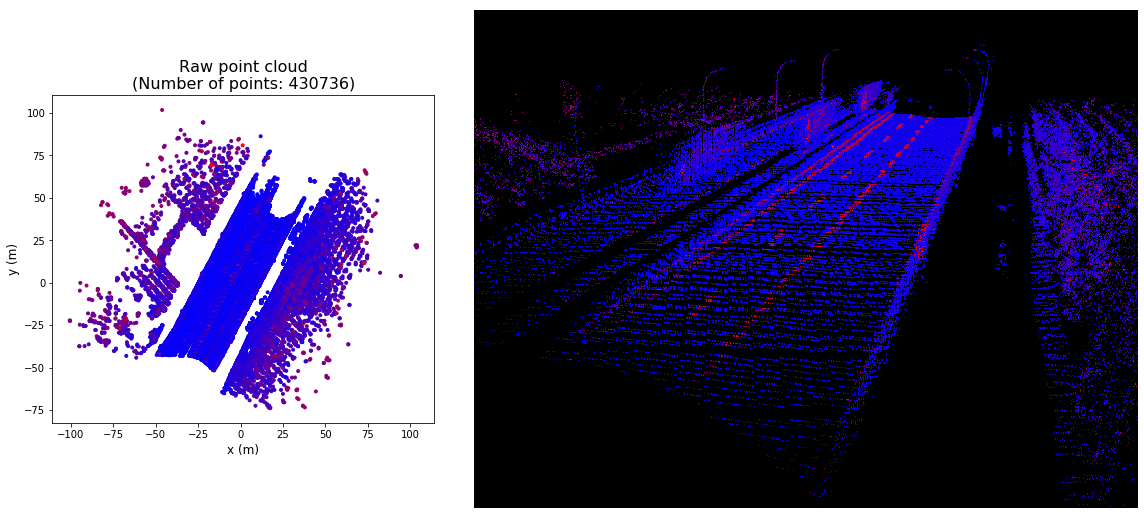

In [5]:
# Plot and save
plot_cloud_2d3d(xyza_src, title='Raw point cloud')
write_cloud_and_figure('result/1_xyza_src', xyza_src)
plt.show()

# Preprocess cloud: downsample + radius filter

In [6]:
xyza_down = downsample(xyza_src, voxel_size=0.1, option='max_alpha')

print("Downsample: {} --> {}".format(
    xyza_src.shape[0], xyza_down.shape[0]))
    
xyza = filter_cloud(xyza_down, nb_points=2, radius=0.5)

print("Filtering:  {} --> {}".format(
    xyza_down.shape[0], xyza.shape[0]))

Downsample: 430736 --> 90183
Filtering:  90183 --> 83906


Time cost of plotting 2D/3D point cloud = 0.60 seconds


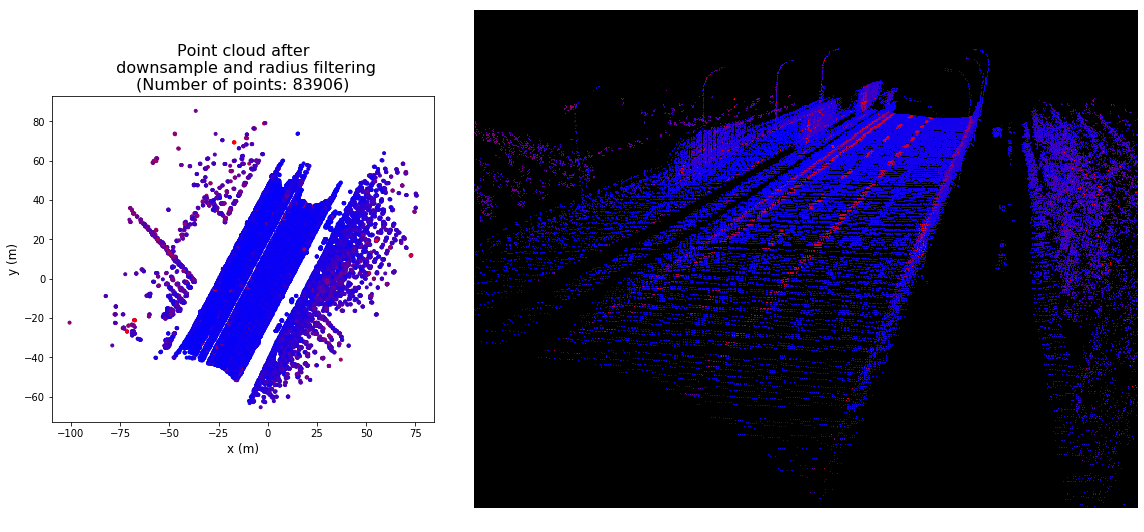

In [7]:
# Plot and save
plot_cloud_2d3d(xyza, title='Point cloud after\n downsample and radius filtering')
write_cloud_and_figure('result/2_xyza.pcd', xyza)
plt.show()

# Get planar regions 
## (i.e., remove regions with large thickness in z axis)

In [8]:
t0 = time.time()
method = ['grid', 'kdtree'][1]

if method == 'grid': # Not so good result, but fast
    inliers = find_plannar_points_by_grid(xyza, grid_size=0.5, max_height=0.1)
    # time: 1s
    
elif method == 'kdtree': # Good result, but slow
    inliers = find_plannar_points_by_kdtree(xyza, num_neighbors=10, max_height=0.1)
    # time: 78s
    
xyza_planar = xyza[inliers, :]

print("\n\nTime cost of {} method: {:.2f} s".format(method, time.time()-t0))
print("Removing non-planar regions:\n{} --> {}".format(
    xyza.shape[0], xyza_planar.shape[0]))

2000/83906, 4000/83906, 6000/83906, 8000/83906, 10000/83906, 12000/83906, 14000/83906, 16000/83906, 18000/83906, 20000/83906, 22000/83906, 24000/83906, 26000/83906, 28000/83906, 30000/83906, 32000/83906, 34000/83906, 36000/83906, 38000/83906, 40000/83906, 42000/83906, 44000/83906, 46000/83906, 48000/83906, 50000/83906, 52000/83906, 54000/83906, 56000/83906, 58000/83906, 60000/83906, 62000/83906, 64000/83906, 66000/83906, 68000/83906, 70000/83906, 72000/83906, 74000/83906, 76000/83906, 78000/83906, 80000/83906, 82000/83906, 

Time cost of kdtree method: 59.83 s
Removing non-planar regions:
83906 --> 33303


Time cost of plotting 2D/3D point cloud = 0.23 seconds


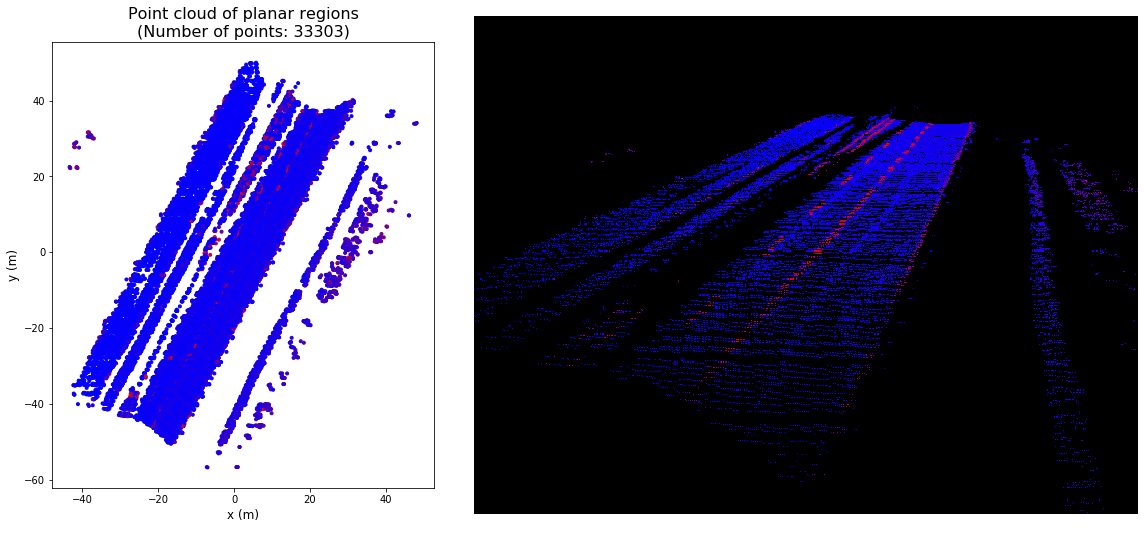

In [9]:
# Plot and save
plot_cloud_2d3d(xyza_planar, title='Point cloud of planar regions')
write_cloud_and_figure('result/3_xyza_planar', xyza_planar)
plt.show()

# Fit road plane by RANSAC

In [10]:
points_xyz = xyza_planar[:,0:3]
plane_model = PlaneModel(feature_dimension=3)
w, inliers = ransac(
    points_xyz,
    plane_model, 
    n_pts_base=3,
    n_pts_extra=50,
    max_iter=100,
    dist_thre=0.3,
    print_time=True,
    debug=False,
)
print("Plane fitting: {} --> {}".format(points_xyz.shape[0], inliers.size ))
xyza_plane = xyza_planar[inliers, :]


--------------------------------
Start RANSAC algorithm ...
Input: num points = 33303, features dim = 3
Config: n_pts_base = 3, n_pts_extra = 50, dist_thre = 0.3

2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 
Time cost for RANSAC = 4.833 seconds
--------------------------------

Plane fitting: 33303 --> 30605


Time cost of plotting 2D/3D point cloud = 0.36 seconds


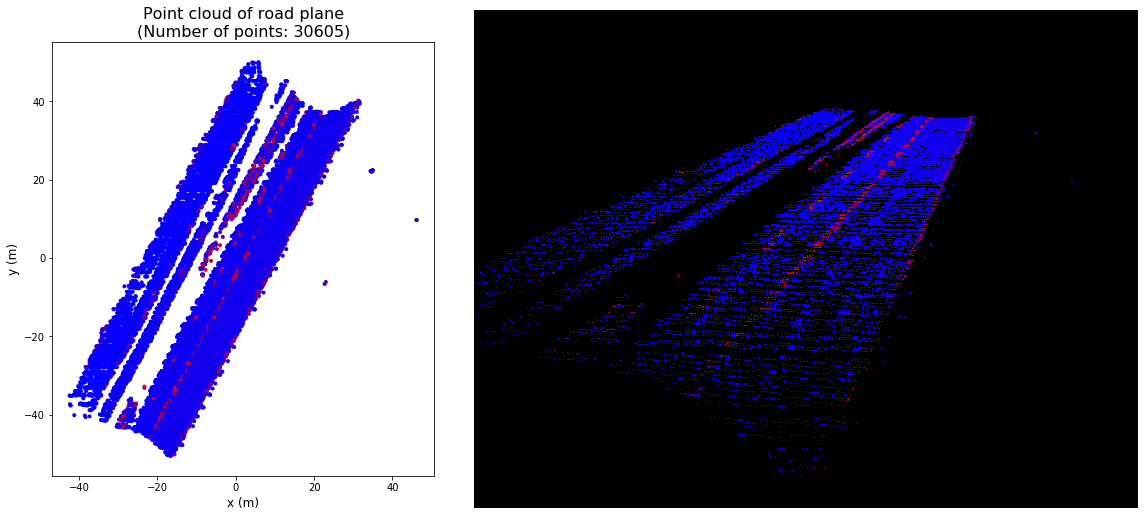

In [11]:
# Plot and save
plot_cloud_2d3d(xyza_plane, title='Point cloud of road plane')
write_cloud_and_figure("result/4_xyza_plane", xyza_plane)
plt.show()

# Threshold on point intensity to get possible lane points

In [12]:
threshold = 0.5
xyza_lanes = xyza_plane[xyza_plane[:, -1]>threshold, :]

print("Threshold on intensity: {} --> {}".format(xyza_plane.shape[0], xyza_lanes.shape[0] ))

Threshold on intensity: 30605 --> 1329


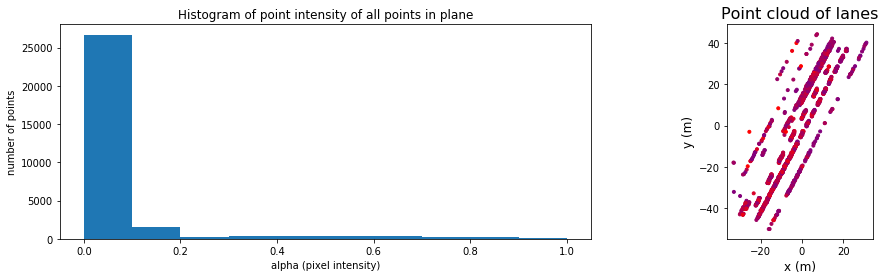

In [13]:
# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Left: histogram of point intensity
ax1.hist(xyza_plane[:,-1], bins=10, range=(0, 1))
ax1.set_title('Histogram of point intensity of all points in plane')
ax1.set_xlabel('alpha (pixel intensity)')
ax1.set_ylabel('number of points')

# Right point cloud of lanes
plot_cloud_2d(xyza_lanes, ax=ax2, title='Point cloud of lanes')
f.tight_layout()

# Plot and save
write_cloud_and_figure("result/5_xyza_lanes", xyza_lanes)
plt.show()

# Use RANSAC to find lane direction

In [14]:
points_xy = xyza_lanes[:,0:2]
line_model = PlaneModel(feature_dimension=2)
w, inliers = ransac(
    points_xy,
    line_model, 
    n_pts_base=2,
    n_pts_extra=10,
    max_iter=1000,
    dist_thre=0.3,
    print_time=True,
    print_iter=False,
    debug=False,
)
print("Line fitting: {} --> {}".format(points_xy.shape[0], inliers.size ))
xyza_lane = xyza_lanes[inliers, :]


--------------------------------
Start RANSAC algorithm ...
Input: num points = 1329, features dim = 2
Config: n_pts_base = 2, n_pts_extra = 10, dist_thre = 0.3


Time cost for RANSAC = 0.494 seconds
--------------------------------

Line fitting: 1329 --> 480


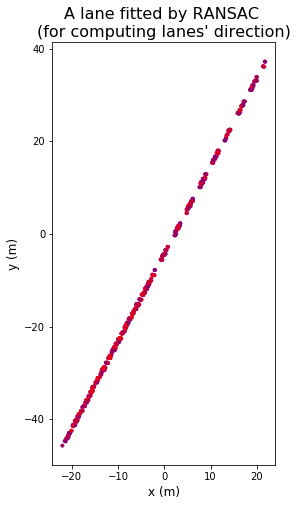

In [15]:
# Plot and save
plot_cloud_2d(xyza_lane, figsize=(4, 8),
    title="A lane fitted by RANSAC \n(for computing lanes' direction)")
write_cloud_and_figure("result/6_xyza_lane", xyza_lane)
plt.show()

# Project points to normal of lane, and do clustering
### (Projection is same as squashing the points along the lane direction)

In [16]:
# Project points

# get line's normal from line parameters w 
# w: w[0] + w[1]*x + w[2]*y = 0
norm_direction = w[1:]
print("Normal of lane: {}".format(norm_direction))

# project points
x = points_xy.dot(norm_direction)
y = np.zeros_like(x)
projections = np.column_stack((x, y))

Normal of lane: [ 0.88461013 -0.46633134]


In [17]:
# Do clustering

# settings
min_points_in_a_lane = 10
max_width_of_a_lane = 0.2 # (meters)

# do clusttering
cluster = Clusterer()
cluster.fit(
    projections, 
    eps=max_width_of_a_lane, 
    min_samples=min_points_in_a_lane)
print("Number of clusters (lanes): ", cluster.n_clusters)

Number of clusters (lanes):  8


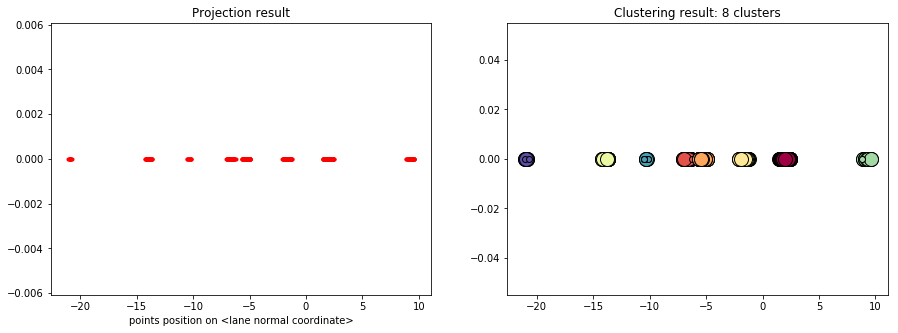

In [18]:
# Plot
fig = plt.figure(figsize=(15, 5))

# Plot left: Projection result
plt.subplot(1,2,1)
plt.scatter(projections[:,0], projections[:,1], marker='.', color='r')
plt.title('Projection result')
plt.xlabel('points position on <lane normal coordinate>')

# Plot right: Clustering result
plt.subplot(1,2,2)
cluster.plot_clusters()

# Plot and save
plt.savefig('result/7_projected_points_and_clustering.jpg')
plt.show()

# Fit a 3D line to each cluster

In [19]:
N = cluster.n_clusters # Number of lanes
lanes_param = []

for i in range(N):
    
    # Get points of label i
    indices = (cluster.labels == i)
    points = xyza_lanes[indices, :].copy()
    
    # Fit line
    x, y, z, alpha = split_into_columns(points)
    lane_direction, a_point_on_lane = fit_3D_line(x, y, z)
    lanes_param.append((lane_direction, a_point_on_lane))
    
    # Print result
    print("\n{}th line, {} points.".format(i+1, points.shape[0]))
    print("Equation: {}".format(
        get_3d_line_equation(lane_direction, a_point_on_lane)
    ))


1th line, 553 points.
Equation: (x+3.26)/(0.46681) == (y+10.42)/(0.88436) == (z-225.09)/(0.00022)

2th line, 156 points.
Equation: (x-0.22)/(0.46460) == (y-14.72)/(0.88552) == (z-225.31)/(0.00038)

3th line, 199 points.
Equation: (x-3.57)/(0.46501) == (y-18.07)/(0.88531) == (z-225.30)/(0.00002)

4th line, 214 points.
Equation: (x+6.22)/(0.46647) == (y+8.22)/(0.88454) == (z-225.20)/(0.00012)

5th line, 49 points.
Equation: (x+15.62)/(-0.46467) == (y-0.28)/(-0.88548) == (z-225.11)/(-0.00081)

6th line, 135 points.
Equation: (x-2.54)/(-0.46442) == (y+15.14)/(-0.88562) == (z-224.85)/(-0.00119)

7th line, 12 points.
Equation: (x+15.15)/(-0.46932) == (y+6.58)/(-0.88303) == (z-225.19)/(-0.00023)

8th line, 11 points.
Equation: (x+13.56)/(-0.46543) == (y-19.15)/(-0.88508) == (z-225.01)/(-0.00041)


# Add fitted line to point cloud, and display

In [20]:
# Generate data points on each of the fitted line
points_of_each_lane = []
for i, lane_param in enumerate(lanes_param):
    vec, p0 = lane_param
    line_pts = p0 + vec * np.mgrid[-80:80:12000j][:, np.newaxis]
    points_of_each_lane.append(line_pts)

# Add these line points to the point cloud of the street
lines_pts = np.vstack(points_of_each_lane)
n = lines_pts.shape[0]
lines_pts_with_alpha = np.hstack((lines_pts, np.ones((n, 1))))
xyza_final = np.vstack((xyza, lines_pts_with_alpha))

Time cost of plotting 2D/3D point cloud = 1.08 seconds


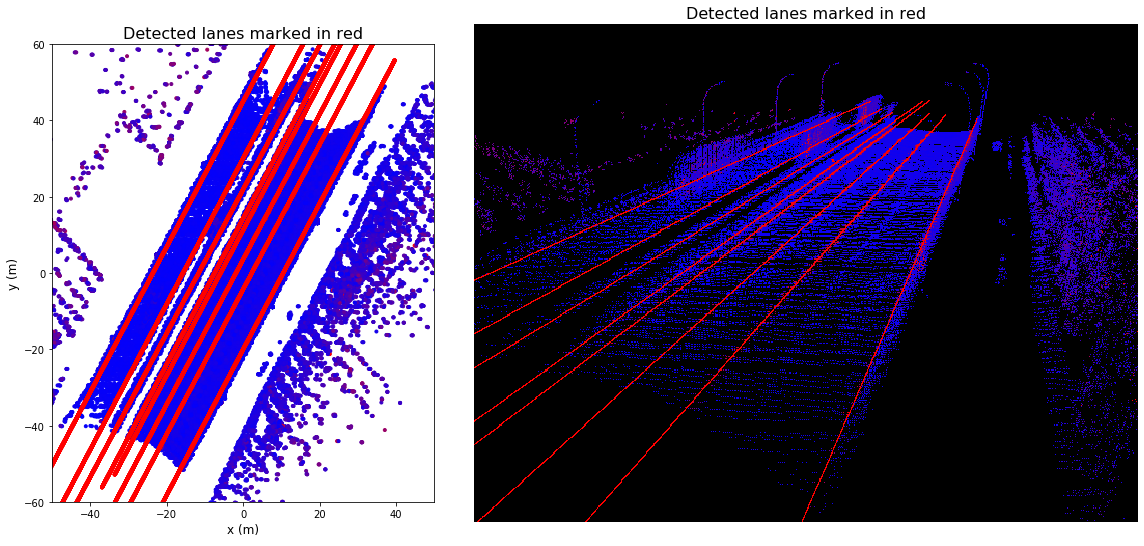

In [21]:
# Plot and save
ax1, ax2 = plot_cloud_2d3d(xyza_final)
ax1.set_title('Detected lanes marked in red', fontsize=16)
ax1.set_xlim([-50, 50])
ax1.set_ylim([-60, 60])
ax2.set_title('Detected lanes marked in red', fontsize=16)
write_cloud_and_figure('result/8_xyza_final', xyza_final)
plt.show()

# Draw raw cloud for comparison

Time cost of plotting 2D/3D point cloud = 2.66 seconds


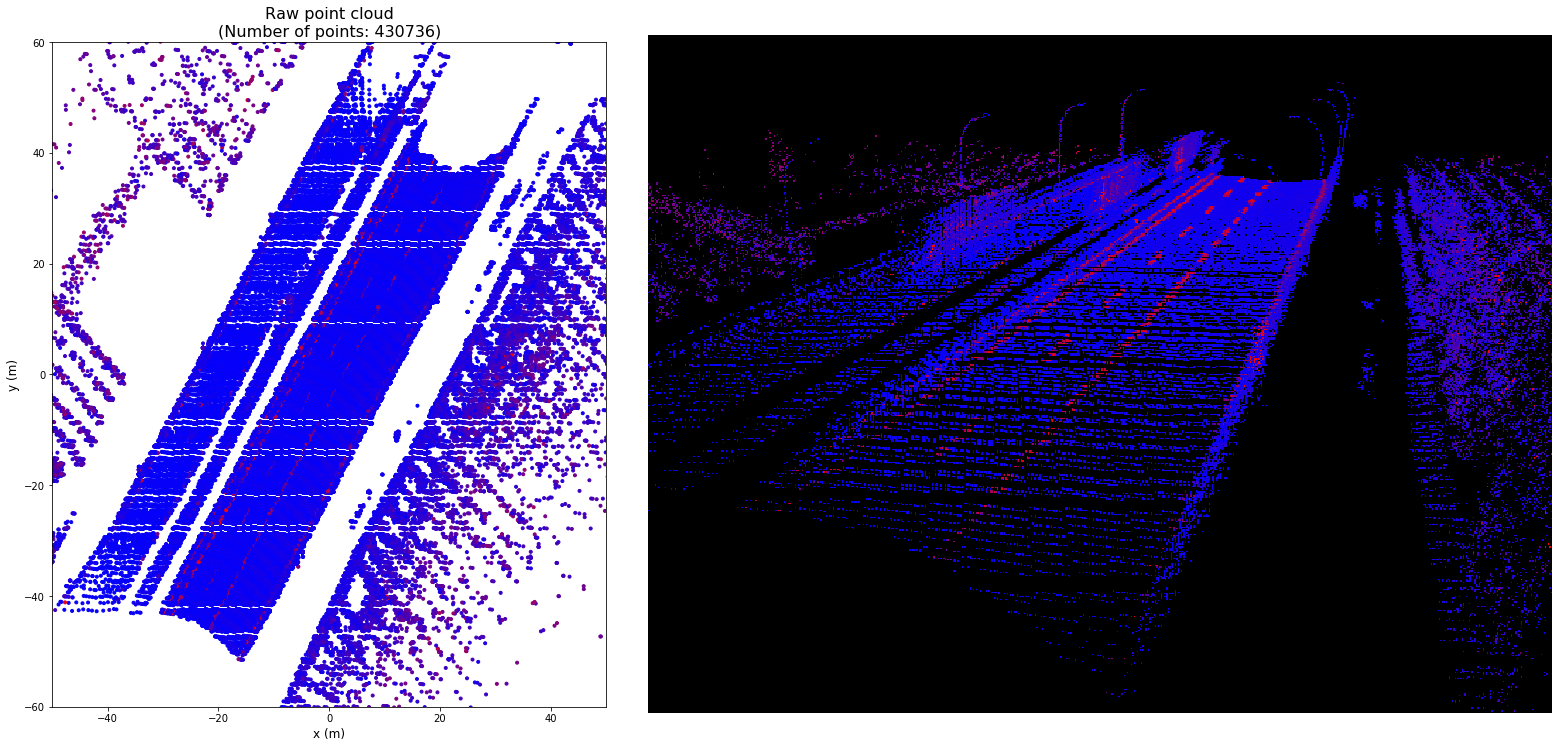

In [22]:
# Plot and save
ax1, ax2 = plot_cloud_2d3d(xyza_src, figsize=(22, 10), title='Raw point cloud')
ax1.set_xlim([-50, 50])
ax1.set_ylim([-60, 60])
write_cloud_and_figure('result/8_xyza_src', xyza_src)
plt.show()

In [23]:
print("Total time of running this jupyter notebook = {:.2f}s".format(
    time.time() - t_start_running_this_jupyter_notebook))

Total time of running this jupyter notebook = 123.72s
